<a href="https://colab.research.google.com/github/oserikov/data-science-nlp/blob/master/3_%D1%81%D0%BD%D0%B8%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%B8_%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Снижение размерности
* PCA
* LSI
* LDA
* t-SNE
* UMAP

##### импорты и вспомогательный код

In [1]:
!pip install umap-learn
!pip install pyLDAvis


     |████████████████████████████████| 1.6MB 3.5MB/s 
     |████████████████████████████████| 552kB 43.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=e52b5aa71cc66bb8548406292e0403c8e68c911967e110bdbb90c57fa62a85ed
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=572a723ec53a86554ad133f38e246a9333708bf2000946619e83d3bd0e8fd5e7
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.pipeline import *
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE, MDS
import re
# import umap
import pyLDAvis
import pyLDAvis.gensim as gensimvis
import gensim
import seaborn as sns

In [0]:
%matplotlib inline

style.use('ggplot')

def draw_subplots(data, colors, plotname, n_clusters, plot_centers=False, 
                  cmap='viridis', header='Clustering example'):
    plot = plotname
    
    # рисуем нули
    plot.axhline(0, color='#afafaf')
    plot.axvline(0, color='#afafaf')
    
    # рисуем точки
    for i in range(n_clusters):
        try:
            sc = plot.scatter(data[i:,0], data[i:,1], s=30, c=colors, cmap=cmap)
        except (KeyError, ValueError) as e: # костыль для бага матплотлиба
            pass
  
    
    # рисуем центроиды
    if plot_centers == True:
        plot.scatter(centers[:,0], centers[:,1], marker="x", c='r')
    
    # подписи осей
    plot.set_xlabel('Principal Component 1')
    plot.set_ylabel('Principal Component 2')
    
    size=81
    
    lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                            label="Feature {:g}".format(i), ls="", marker="o")[0]
    handles = [lp(i) for i in np.unique(colors)]
    plot.legend(handles=handles)

    # заголовок
    plot.set_title(header)

## Возьмём какие-то данные и поснижаем у них размерность
Давайте возьмём для примера датасет новостей из sklearn. Снижение размерности будем рассматривать на его Tf-Idf представлении. 

In [5]:
cats = ['talk.religion.misc', 'sci.space', 'talk.politics.mideast', 'comp.graphics']

dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, categories=cats)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

data = dataset.data
labels = dataset.target

3528 documents
4 categories


In [6]:
vect = TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,3), analyzer='word', stop_words ='english')
X = vect.fit_transform(data)
X.shape

(3528, 37147)

### Кластеризуем данные
Давайте сделаем наивную кластеризацию наших данных, чтобы потом можно было посмотреть на неё в пространстве пониженной размерности.

**Важно!** Несморя на то, что разные методы снижения размерности дадут разные картинки, результаты кластеризации от этого никак не изменятся! Мы просто видим различные проекции наших данных на плоскость, а присвоенные им метки классов/кластеров от этого не меняются.

In [7]:
n_clusters = len(dataset.target_names)
clf = KMeans(n_clusters=n_clusters)

%time result = clf.fit_predict(X)

CPU times: user 3min 4s, sys: 30.4 s, total: 3min 34s
Wall time: 3min 1s


### Учим снижение размерности для данных

#### LSI


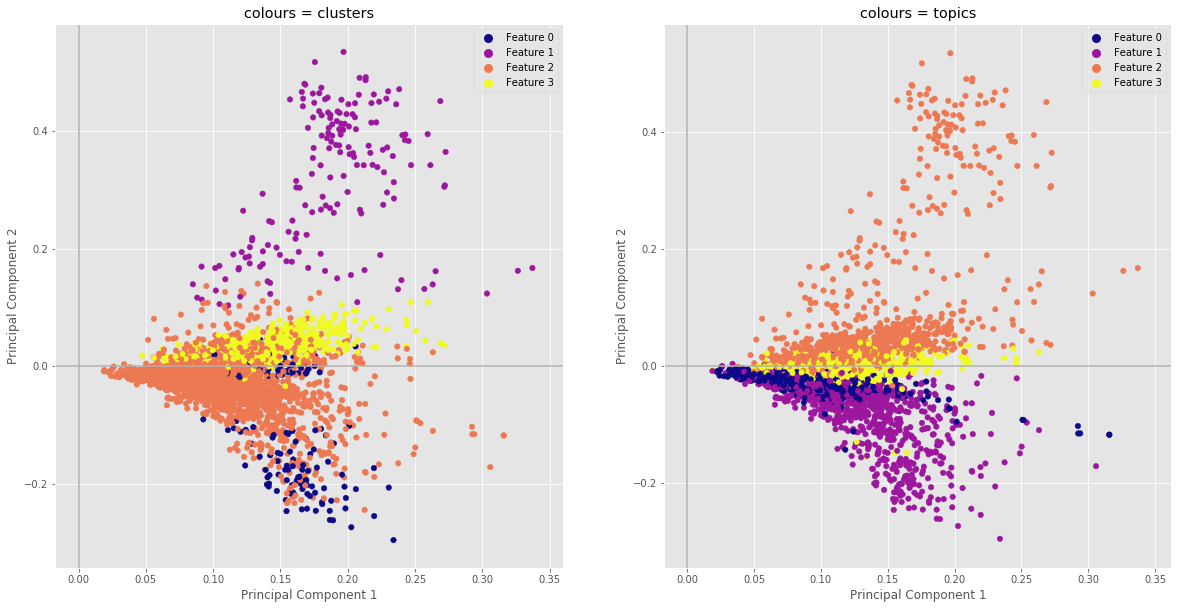

In [8]:
svd = TruncatedSVD(n_components=2)
X_2D_SVD = svd.fit_transform(X.todense())


# рисуем сабплоты
fig, ((plot1, plot2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))

# цвета = кластеры
draw_subplots(X_2D_SVD, clf.labels_, plot1, n_clusters, header='colours = clusters', cmap='plasma', plot_centers=False)

# цвета = темы
draw_subplots(X_2D_SVD, labels, plot2, n_clusters, header='colours = topics', cmap='plasma', plot_centers=False)

#### PCA

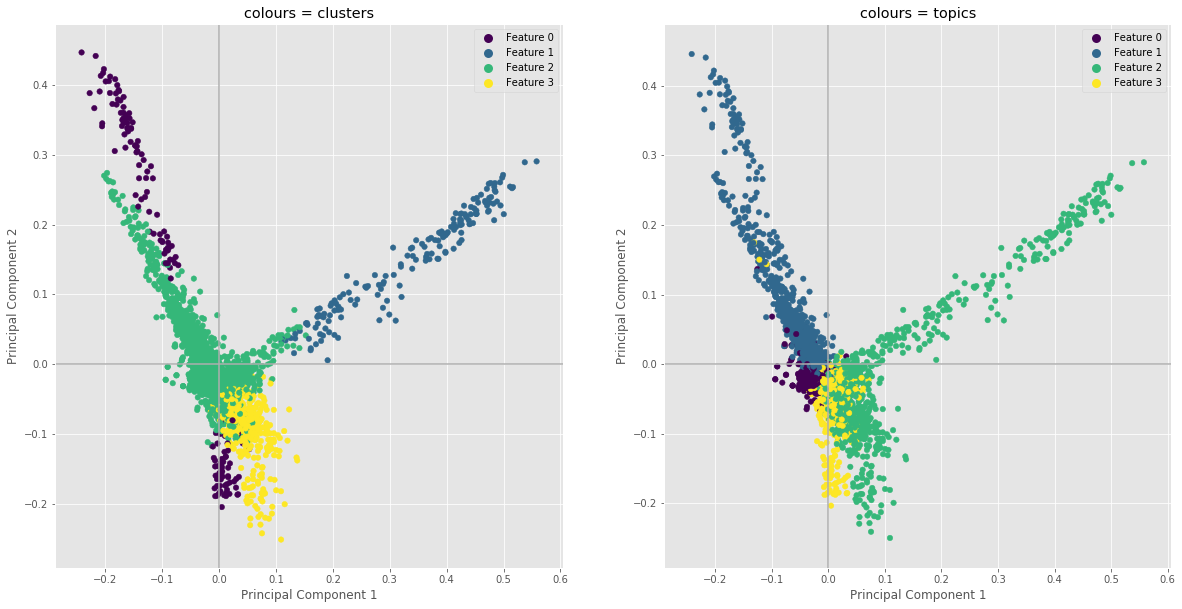

In [9]:
pca = PCA(n_components=2)
X_2D_PCA = pca.fit_transform(X.todense())
centers = pca.transform(clf.cluster_centers_)

# рисуем сабплоты
fig, ((plot1, plot2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))

# цвета = кластеры
draw_subplots(X_2D_PCA, clf.labels_, plot1, n_clusters, header='colours = clusters')

# цвета = темы
draw_subplots(X_2D_PCA, labels, plot2, n_clusters, header='colours = topics')

### LDA

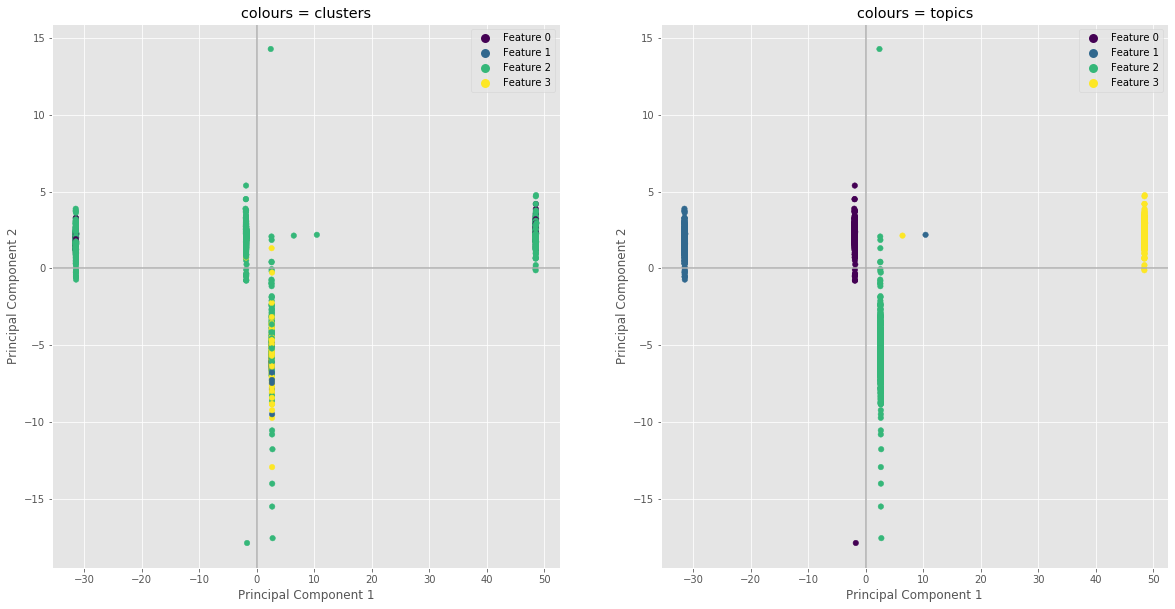

In [10]:

lda = LinearDiscriminantAnalysis(n_components=2)

X_2D_LDA = lda.fit(X.todense(), labels).transform(X.todense())

# рисуем сабплоты
fig, ((plot1, plot2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))

# цвета = кластеры
draw_subplots(X_2D_LDA, clf.labels_, plot1, n_clusters, header='colours = clusters')

# цвета = темы
draw_subplots(X_2D_LDA, labels, plot2, n_clusters, header='colours = topics')


#### t-SNE

In [0]:
%time X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X.todense())

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

##### Хаки с t-SNE
Можно предснизить размерность e.g. PCA, а потом применять t-SNE. Говорят, иногда работает лучше.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3528 samples in 0.005s...
[t-SNE] Computed neighbors for 3528 samples in 1.321s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3528
[t-SNE] Computed conditional probabilities for sample 2000 / 3528
[t-SNE] Computed conditional probabilities for sample 3000 / 3528
[t-SNE] Computed conditional probabilities for sample 3528 / 3528
[t-SNE] Mean sigma: 0.081499
[t-SNE] Computed conditional probabilities in 0.306s
[t-SNE] Iteration 50: error = 80.1037598, gradient norm = 0.0224144 (50 iterations in 2.835s)
[t-SNE] Iteration 100: error = 75.7816467, gradient norm = 0.0034897 (50 iterations in 1.821s)
[t-SNE] Iteration 150: error = 75.6234055, gradient norm = 0.0036057 (50 iterations in 1.704s)
[t-SNE] Iteration 200: error = 75.5900803, gradient norm = 0.0014734 (50 iterations in 1.706s)
[t-SNE] Iteration 250: error = 75.5830231, gradient norm = 0.0015569 (50 iterations in 1.687s)
[t-SNE] KL divergence after 250 iterat

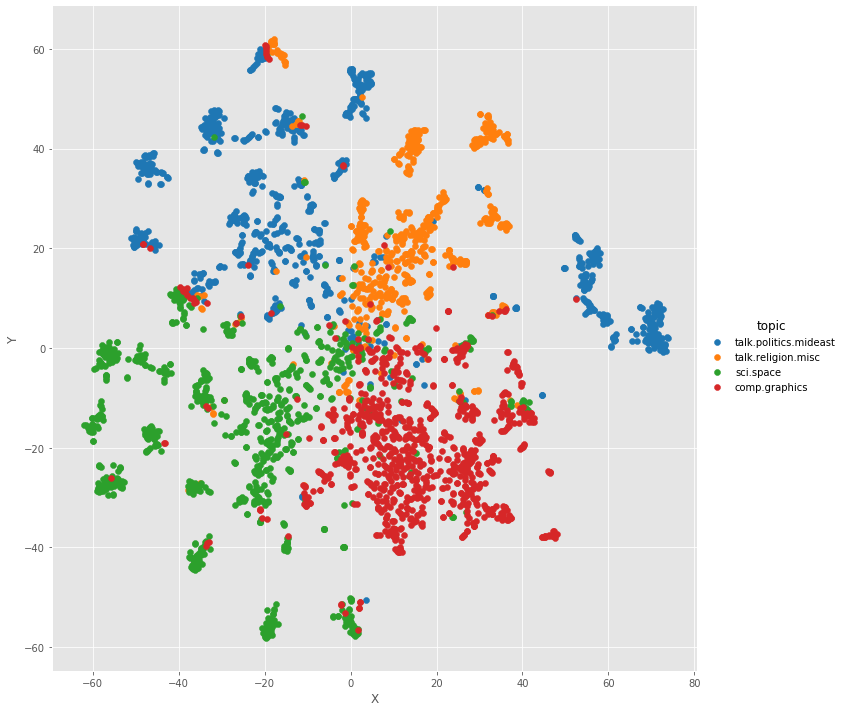

In [8]:
svd50 = TruncatedSVD(n_components=50)
X_50_SVD = svd50.fit_transform(X.todense())
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_50_SVD)

sns.set_palette('tab10')

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

In [0]:
pca30 = PCA(n_components=30)
X_30_PCA = pca30.fit_transform(X.todense())
X_embedded_2 = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_30_PCA)

sns.set_palette('tab10')

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

### UMAP



In [0]:
umap_emb = umap.UMAP()
X_2D_umap = umap_emb.fit_transform(X.todense())


# рисуем сабплоты
fig, ((plot1, plot2)) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))

# цвета = кластеры
draw_subplots(X_2D_umap, clf.labels_, plot1, n_clusters, header='colours = clusters')

# цвета = темы
draw_subplots(X_2D_umap, labels, plot2, n_clusters, header='colours = topics')

## Задание
#### 1
Проделайте все то же самое с другим набором тем или на каком-нибудь вашем датасете.  
Хорошо ли отделяются друг от друга близкие темы (например, 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space')?  
Соответствует ли количество тем количеству кластеров, или же кластеров на глаз больше/меньше?

#### 2
Задайте побольше классов (например, 20) в KMeans, а потом преобразуйте данные с помощью t-SNE и раскрасьте точки на графике в соответствии с полученными из KMeans кластерами.  
Насколько результаты кластеризации совпадают с проекцией t-SNE?

#### 3
Возьмите датасет русских новостей, e.g. той же Ленты, что и на всех занятиях, сделайте снижение размерности и посмотрите, сочетается ли оно с оригинальными классами.

# Тематическое моделирование


In [15]:
!wget https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/rus_stopwords.txt
!wget https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/polkrug_lem.txt

--2019-12-14 09:38:19--  https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/rus_stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4786 (4.7K) [text/plain]
Saving to: ‘rus_stopwords.txt’

rus_stopwords.txt   100%[===================>]   4.67K  --.-KB/s    in 0s      

2019-12-14 09:38:19 (59.1 MB/s) - ‘rus_stopwords.txt’ saved [4786/4786]

--2019-12-14 09:38:20--  https://raw.githubusercontent.com/oserikov/data-science-nlp/master/data/polkrug_lem.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18309964 (1

In [16]:
with open('rus_stopwords.txt', 'r', encoding='utf-8') as f:
    sw = f.read().split('\n')
    
sw[40:50]

['ведь',
 'весь',
 'весьма',
 'видеть',
 'видит',
 'вместе',
 'во',
 'восемь',
 'вот',
 'впрочем']

In [17]:

with open('polkrug_lem.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    
texts = text.split('\n\n')

punct = '[!"#$%&()*+,./:;<=>?@[\]^_`{|}~„“«»†*/\—–‘’]'

texts = [re.sub('\n', ' ', text) for text in texts]
texts = [re.sub(punct, '', text) for text in texts]

tokenized_texts = []
for text in texts:
    text = [w for w in text.split() if w not in sw]
    tokenized_texts.append(text)
    
tokenized_texts[0][:10]

['лев',
 'толстой',
 'анна',
 'каренина',
 'писать',
 'счастливый',
 'семья',
 'похожий',
 'друг',
 'друг']

In [18]:
from gensim.models import *
from gensim import corpora
from gensim import similarities


print('Making dictionary...')
dictionary = corpora.Dictionary(tokenized_texts)
print('Original: {}'.format(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.9, keep_n=None)
dictionary.save('polkrug.dict')
print('Filtered: {}'.format(dictionary))

print('Vectorizing corpus...')
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
corpora.MmCorpus.serialize('polkrug.model', corpus)

Making dictionary...
Original: Dictionary(43034 unique tokens: ['10', '1964', 'август', 'адрес', 'анна']...)
Filtered: Dictionary(12866 unique tokens: ['10', '1964', 'август', 'адрес', 'анна']...)
Vectorizing corpus...


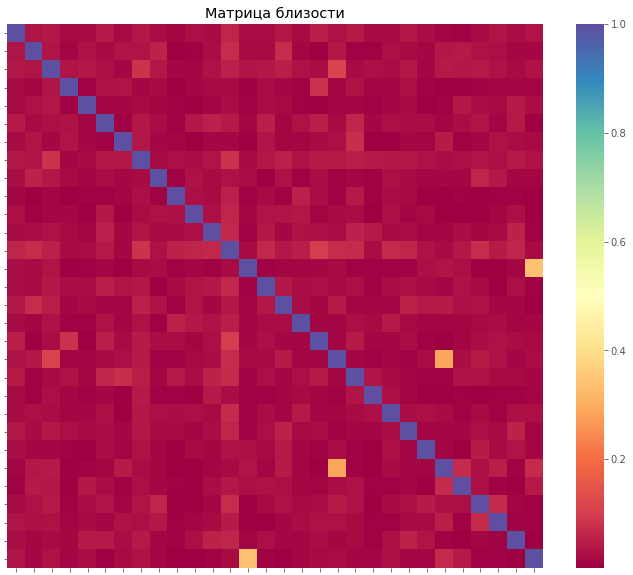

In [19]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

# tf-idf векторах
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# создание случайной выборки
sampling_tfidf = random.choices(corpus_tfidf, k=30)

# вычисление сходства по косинусной мере на tf-idf векторах
index = similarities.MatrixSimilarity(sampling_tfidf)
sims = index[sampling_tfidf]

plt.figure(figsize = (12,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [0]:
lsi = lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=5, chunksize=50)


In [21]:
lsi.show_topics(num_topics=5, num_words=10, formatted=False) # можно показать не все темы, а только часть


[(0,
  [('год', 0.3773873006608409),
   ('город', 0.2333666294887972),
   ('салехард', 0.2153879352123726),
   ('работа', 0.17142590639985475),
   ('день', 0.1483354651533078),
   ('человек', 0.14314857242856016),
   ('россия', 0.12241392516943149),
   ('ребенок', 0.12110045021664712),
   ('городской', 0.10889760636530545),
   ('округ', 0.10420592610514046)]),
 (1,
  [('год', -0.34569587314999234),
   ('война', -0.1850367448009637),
   ('салехард', 0.16179480716860908),
   ('сторона', 0.1445209004031013),
   ('город', 0.1343723416286759),
   ('полиция', 0.13246652298057926),
   ('победа', -0.12239115787515994),
   ('работа', 0.10607344932000769),
   ('май', -0.10483660201764908),
   ('великий', -0.10407157547046988)]),
 (2,
  [('война', -0.19164517485359725),
   ('победа', -0.15899616892906043),
   ('июнь', 0.14841629621355543),
   ('россия', 0.14686299628502458),
   ('улица', 0.13971407687058163),
   ('библиотека', 0.13794187009664066),
   ('социальный', -0.13742445259378624),
   ('ма

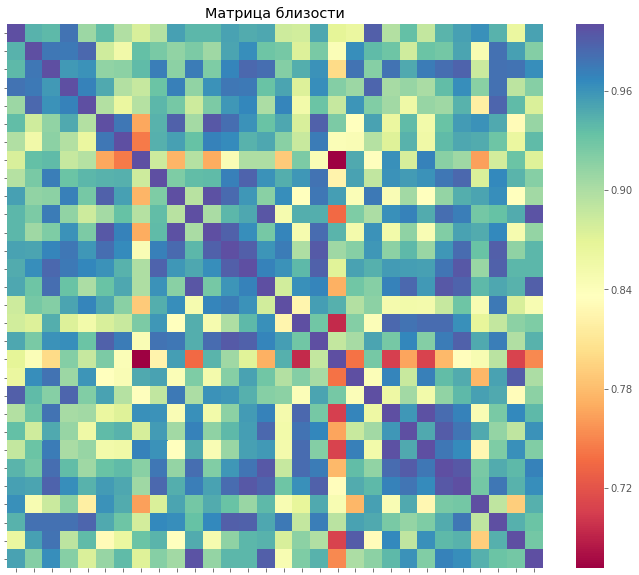

In [22]:
sampling = random.choices(corpus, k=30)

sampling_lsi = lsi[sampling]
index = similarities.MatrixSimilarity(lsi[sampling])
sims = index[sampling_lsi]
sims  = (sims + 1)/2.

plt.figure(figsize = (12,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [35]:

%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=50, update_every=1, passes=2)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

CPU times: user 6.95 s, sys: 772 ms, total: 7.72 s
Wall time: 6.87 s


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [36]:
lda.show_topics(num_topics=5, num_words=10, formatted=False)


[(0,
  [('год', 0.013691969),
   ('россия', 0.0066167205),
   ('часть', 0.0047750366),
   ('человек', 0.004608663),
   ('район', 0.0045374334),
   ('северный', 0.004151823),
   ('арктика', 0.0040619452),
   ('время', 0.004032679),
   ('салехард', 0.004010271),
   ('сибирский', 0.0037485037)]),
 (1,
  [('город', 0.020112412),
   ('день', 0.012941964),
   ('салехард', 0.009975725),
   ('улица', 0.009517561),
   ('городской', 0.007851163),
   ('иван', 0.007820968),
   ('дом', 0.0061213477),
   ('администрация', 0.0055278246),
   ('война', 0.0050889486),
   ('глава', 0.0048027444)]),
 (2,
  [('год', 0.02442945),
   ('человек', 0.009839554),
   ('обдорск', 0.008246559),
   ('ребенок', 0.007913168),
   ('жизнь', 0.0073006107),
   ('время', 0.006235792),
   ('первый', 0.0058275457),
   ('работать', 0.005527862),
   ('русский', 0.005314166),
   ('история', 0.004681337)]),
 (3,
  [('год', 0.012805167),
   ('россия', 0.011290494),
   ('проект', 0.010943122),
   ('округ', 0.010348306),
   ('ямал'

In [37]:


%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 9.9 s, sys: 320 ms, total: 10.2 s
Wall time: 10min 21s
